# Objectives notebook

- Understand the computations of an OLS
- Detect problem
- Check where to look in case of abnomalies
- Have a tool to quicly visualize the issues rise by the fixed effect/factor: lots of single point, many groups/ loss of accuracy

## Least Squares Estimates

In a simple OLS regression, the computation of $\alpha_0$ and $\beta_0$ is straightforward. We don't mean to show the derivation in this tutorial. We will only write the formula.

We want to estimate: $y = \beta_0+\beta_1x+\varepsilon$

The goal of the OLS regression is to minimize the following equation:

$\sum (y_i-\hat{y}_i)^2= \sum e_i^2$

where $y_i$ is the actual values and $\hat{y}_i$ is the predicted values.

The solution for $\beta$ is $\beta_0 = \bar{y}-\beta_1\bar{x}$

Note that $\bar{x}$ means the average value of $x$

The solution for $\beta$ is $\beta = \frac{Cov(x,y)}{Var(x)}$

## Multiple Linear regression

More practical applications of regression analysis employ models that are more complex than the simple straight-line model. The probabilistic model that includes more than one independent variable is called multiple regression models. The general form of this model is:

$y = \beta_0+\beta_1x_1+\beta_2x_2+...+\beta_kx_k+\varepsilon$

In matrix notation, you can rewrite the model:

$Y = \beta X+\varepsilon$
The dependent variable $y$ is now a function of $k$ independent variables. The value of the coefficient $\beta_i$ determines the contribution of the independent variable $x_i$ and $\beta_0$.

We briefly introduce the assumption you make about the random error $\varepsilon$ of the OLS:

- Mean equal to 0
- Variance equal to $\sigma^2$
- Normal distribution
    - Random errors are independent (in a probabilistic sense)
    
You need to solve for $\beta$, the vector of regression coefficients that minimise the sum of the squared errors between the predicted and actual $Y$ values.

The closed-form solution is:

$\beta = (X^TX)^{-1}X^TY$

with:

$T$ indicates the transpose of the matrix X
$(X^TX)^{-1}$ indicates the invertible matrix
We use the mtcars dataset. The goal is to predict the mile per gallon over a set of features.

In [0]:
import pandas as pd
import numpy as np
import researchpy as rp
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="ticks")

### Prepare the data
If we have categorical variable, we need to convert them

In [0]:
def prepare_dataset(list_variables, list_categoricals, y, df):
    df_new = df[list_variables]
    df_new = df_new.drop(columns = list_categoricals) ### Drop cate
    df_new = df_new.drop(columns = y) ### Drop y
    #### Create dummy
    temp = df[list_categoricals]
    df_cat = pd.concat([pd.get_dummies(temp[col], drop_first=True) for col in temp], axis=1) ## create categoricals
    df_final = pd.concat([df_new, df_cat], axis=1)
    #### Y
    Y = df[y]
    col_name = list(df_final)
    col_name.insert(0,'intercept')
    return df_final, Y, col_name

#### Formula

$\hat { \beta } = \left( X ^ { \prime } X \right) ^ { - 1 } X ^ { \prime } y$

Linear algebra x transpose x
$$\left( \begin{array} { l l l } { 1 } & { 1 } & { 1 } \\ { 2 } & { 3 } & { 4 } \end{array} \right) \left( \begin{array} { l l } { 1 } & { 2 } \\ { 1 } & { 3 } \\ { 1 } & { 4 } \end{array} \right) = \left( \begin{array} { l l } { 3 } & { 9 } \\ { 9 } & { 29 } \end{array} \right)$$

trying to find the regression parameters, the slope and intercept of the fitted line. Recall that when you calculate those parameters, $$\sum x _ { i } \text { and } \sum x _ { i } ^ { 2 }$$, $$n$$, and the sums, among other things. Now, if you look at the entries in the result (referring  to your example), you see that the result has the form.
$$\left( \begin{array} { c c } { \boldsymbol { n } } & { \sum x _ { i } } \\ { \sum x _ { i } } & { \sum x _ { i } ^ { 2 } } \end{array} \right)$$
Inverse Matrix



In [0]:
def get_beta(X, y):
    intercept = np.ones(len(X))
    X_mat = np.c_[intercept, X] ### Construct matrix with intercept
    X_t = np.transpose(X_mat) ### Compute the transpose
    XtX = np.dot(X_t, X_mat) ### Mutliply matrix Xt X
    inverse = np.linalg.inv(XtX) ### Compute inverse
    y_dot = np.dot(X_t, y) #### Weighed sum of Y knowing X. For intercept, sum of Y
    beta = np.dot(inverse, y_dot)
    return beta, inverse, X_mat, y_dot

#### Compute Standard error

$$\operatorname { Var } [ \hat { \beta } | X ] = s ^ { 2 } \left( X ^ { \top } X \right) ^ { - 1 }$$

with 

$$
s ^ { 2 } = \frac { \hat { \varepsilon } ^ { \top } \hat { \varepsilon } } { n - p }
$$

In principle, the SE reflects the degree of uncertainty or the lack of information for getting a 'good' ( that is reliable) estimate of a parameter. Therefore if you keep everything else the same ( eg the same variation in the response, the same number of observations) but you increase the number of separate parameters to be estimated there will be less information per parameter to get the estimate, and hence larger standard error. Precisely what happens will depend on the degree of variation in the additional X variable that is included and how collinear it is with already included variables.

If your confidence interval is too wide, you cannot be very certain about the true value of a parameter, such as the mean. However, you can use several strategies to reduce the width of a confidence interval and make your estimate more precise.

- Increase the sample size 
    - Often, the most practical way to decrease the margin of error is to increase the sample size

- Reduce variability 
    - The less that your data varies, the more precisely you can estimate a population parameter.  That's because reducing the variability of your data decreases the standard deviation and, thus, the margin of error for the estimate. Although it can be difficult to reduce variability in your data, you can sometimes do so by adjusting how you collect data.

In [0]:
def standard_error_coef(X, y, get_t_stat =  False):
    beta, inverse, X_mat, y_null = get_beta(X, y)
    ### Compute predicted value 
    pred = np.dot(np.transpose(beta), np.transpose(X_mat))
    resid = y - np.transpose(pred)
    up = np.dot(np.transpose(resid),
                resid)
    n = len(X_mat)
    p = X_mat.shape[1]
    sdr = up/(n-p)
    sd_error = np.sqrt(np.diag(inverse*sdr))
    if get_t_stat == True:
        r = np.ravel(beta)/sd_error
    else:
        r = sd_error
    return r

### Post estimation plots

In [0]:
def prediction(X, y, df, list_variables):
    df_new = df[list_variables]
    beta, inverse, X_mat, y_null = get_beta(X, y)
    ### Compute predicted value 
    pred = np.dot(np.transpose(beta), np.transpose(X_mat))
    resid = y - np.transpose(pred)
    df_new['resid'] = resid
    return df_new

In [0]:
def errr_vs_fitted_plot(df, residual, Y):
    plot_lm_1 = plt.figure(1)
    plot_lm_1.set_figheight(5)
    plot_lm_1.set_figwidth(5)
    plot_lm_1.axes[0] = sns.residplot(residual, Y, data=df, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = df[residual].abs().sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                               xy=(df[residual][i], 
                                   df[residual][i]))

### Compute the QQ plot
Need the studentized residual

In [0]:
def QQ_plot(df, residual, Y):
    sigma = df[residual].std()
    internal_studentize_resid = [df[residual][i]/sigma for i in range(len(df[residual]))] 

    QQ = ProbPlot(np.array(internal_studentize_resid))
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

    plot_lm_2.set_figheight(5)
    plot_lm_2.set_figwidth(5)

    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(internal_studentize_resid)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   internal_studentize_resid[i]))

In [0]:
def test_shapiro(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [0]:
def get_postprediction(df, residual, Y): 
    errr_vs_fitted_plot(df, residual, Y)
    QQ_plot(df, residual, Y)
    test_shapiro(df)

### Get the variability in the computation of beta

In [0]:
def variabilty_group_no_sign(X, y, i, j, col_name):
    array = get_beta(X = X, y =Y)[1][i:j+1]
    X_t_y = get_beta(X = X, y =Y)[3]
    m = pd.DataFrame(X_t_y * np.transpose(array), columns= l_col[i:j+1])
    m['coef'] = col_name
    m_copy = m.copy()
    m_copy['X_t_y'] = X_t_y
    m_copy = m_copy.sort_values(by=['X_t_y'])
    melt_m = pd.melt(m, id_vars=['coef'])
    c_v = melt_m.groupby('variable')['value'].std()/melt_m.groupby('variable')['value'].mean()
    melt_m = melt_m.sort_values(by=['value'])
    sns.barplot(x="coef", y="value", hue="variable", data=melt_m)
    print('CV and X_t_y')
    print('\n', c_v, '\n', m_copy)

### Check OLS for improvement

In [0]:
def variablity(X, y): 
    intercept = np.ones(len(X))
    X_mat = np.c_[intercept, X] ### Construct matrix with intercept
    X_t = np.transpose(X_mat)
    v = np.dot(X_t, y)
    print('\n max sum y is', np.sum(y))
    print('\n Weighed sum of Y knowing X. For intercept, sum of Y \n',np.transpose(X_t), Y[:3])
    print('\n If the output equal to zero or equal to Y, it means there is no information to learn from' )
    return v

In [0]:
def coef_variation(X, y,x_pred, df, group_sd = False):
    var = df[X]
    df_y = df[y]
    df_x_pred = df[x_pred]
    if group_sd == False:
        sd_y = df_y.std() 
    else:
        sd_y = df.groupby(X)[y].std()
    mean_y = df.groupby(X)[y].mean()
    print('Summary stat Y')
    sum_y =  rp.summary_cont(df_y)
    sum_y_group = rp.summary_cont(df_y.groupby(var))
    print('\n', sum_y, '\n', sum_y_group)
    print('\n----Coef of variation----')
    c_v = sd_y/mean_y
    print(c_v)
    cov_g1_g2 = df[[X, x_pred,y]].groupby(X).cov()
    print('\n----Covariance----')
    print(cov_g1_g2)
    #### Add ANOVA
    print('----Plots----')
    sns.set_style('darkgrid')
    fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
    ### Violon + jitter
    sns.violinplot(x=var, y=df_y, data=df, inner=None, ax=axarr[0][1])
    sns.swarmplot(x=var, y=df_y, data=df,color="k", size=3, ax=axarr[0][1])
    #### Box plot
    sns.boxplot(x=var, y=df_y, data=df, ax=axarr[0][0])
    ### Sum by group
    sns.barplot(x=var, y=df_y, data=df, ax=axarr[1][0])
    sns.scatterplot(x=df_x_pred, y=df_y, hue=var, size=var, data=df, palette="Set1", ax=axarr[1][1])
    return

In [0]:
def facet_gg(df, g1, g2, X, y):
    #x_axis = df[X]
    #y_axis = df[y]
    #g1_axis = df[g1]
    #g2_axis = df[g1]
    g = sns.FacetGrid(df, col="gear_t",  row="cyl_t")
    g = g.map(plt.hist, y)

    h = sns.FacetGrid(df, col=g1,  hue=g2)
    h = h.map(plt.scatter, X, y, edgecolor="w").add_legend()
    desc = df.groupby([g1, g2])[y].describe()
    return desc

## Test Functions

This part test if the method employed to check abnomalies is effective.

Steps: 

1. Compute Beta
2. Compute SE
3. Print post estimation plot for Normality of the residual
4. Plot the inverse matrix to visualize what variables lead to non-significant of the coef
5. Plot group description to vizualise the variability

For the first exercices, we will compute the coefficient of:

- cyl: 3 factors
- disp: continuous
- mpg: dependant variables

In [0]:
df = pd.read_csv('data.csv')
map_dict = {3: "3G", 4: "4G", 5 : "5G"}
map_dict_1 = {4: "4C", 6: "6C", 8: "8C"}
df["gear_t"] = df["gear"].map(map_dict)
df["cyl_t"] = df["cyl"].map(map_dict_1)
df.head(5)

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,gear_t,cyl_t
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,4G,6C
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,4G,6C
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,4G,4C
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,3G,6C
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,3G,8C


In [0]:
list_variables = ['mpg','cyl', 'disp']
list_categoricals = ['cyl']
y = ['mpg']
X, Y, l_col = prepare_dataset(list_variables = list_variables,
                list_categoricals = list_categoricals, 
                y = y, df = df)

In [0]:
X.describe()

,disp,6,8
count,32.000000,32.000000,32.000000
mean,230.721875,0.218750,0.437500
std,123.938694,0.420013,0.504016
min,71.100000,0.000000,0.000000
25%,120.825000,0.000000,0.000000
50%,196.300000,0.000000,0.000000
75%,326.000000,0.000000,1.000000
max,472.000000,1.000000,1.000000


1. Compute the beta

- intercept
- disp
- cyl g6
- cyl  g8

the objective is not to get pretty output, just to make sure the computations are correct

In [0]:
get_beta(X = X, y =Y)[0]

array([[ 2.95347678e+01],
       [-2.73086433e-02],
       [-4.78584624e+00],
       [-4.79208587e+00]])

Intermediate steps to compute the coef of cyl g6

In [0]:
print(get_beta(X = X, y =Y)[1][2], '\n', get_beta(X = X, y =Y)[3])
np.dot(get_beta(X = X, y =Y)[1][2], get_beta(X = X, y =Y)[3])

[ 0.01542982 -0.00101144  0.31283836  0.34170894] 
 [[   642.9 ]
 [128705.08]
 [   138.2 ]
 [   211.4 ]]


array([-4.78584624])

2. get the standard error

When get_t_stat is turn to False, it computes the standard error, otherwise, it computes the t-stat. Note that, the t-stat ) should be above 2.02 at 95 percent for 32 observations

In [0]:
standard_error_coef(X = X, y =Y, get_t_stat = False)

array([1.42662052, 0.01060974, 1.64982267, 2.88681844])

In [0]:
standard_error_coef(X = X, y =Y, get_t_stat = True)

array([20.70260967, -2.5739214 , -2.90082463, -1.65998866])

Cyl 8 is not significant. Let's figure out why after 

3. Plot the residual

Note that the standard error of the error after the standard error of the coef. Besides, an increase of the number of parameters increase the standard error of the error

Statistics=0.615, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


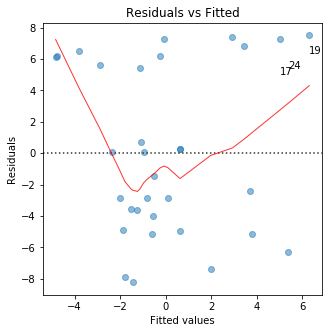

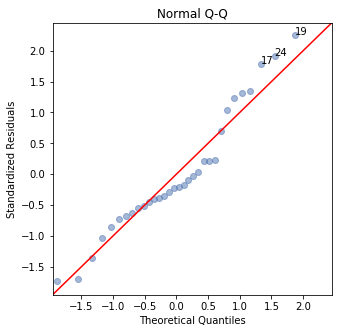

In [0]:
residual_df = prediction(X = X, y =Y, df = df, list_variables = list_variables)
get_postprediction(df = residual_df, residual = 'resid', Y = 'mpg')

Issue, the residual does not look gaussian

In [0]:
variablity(X = X[:3], y = Y[:3])


 max sum y is mpg    64.8
dtype: float64

 Weighed sum of Y knowing X. For intercept, sum of Y 
 [[  1. 160.   1.   0.]
 [  1. 160.   1.   0.]
 [  1. 108.   0.   0.]]     mpg
0  21.0
1  21.0
2  22.8

 If the output equal to zero or equal to Y, it means there is no information to learn from


array([[  64.8],
       [9182.4],
       [  42. ],
       [   0. ]])

4. Plot variability of the coef not significant

Let's plot the inverse of matrix of the coef cyl8 to see which coef affect the variability of cyl8.
The function below plots the inverse matrix in the other group, cyl6.

The sum of each column gives the coefficient. 

- The larger the X_t_y the larger the sum of y for this variables.
- The larger the $X ^ { \prime } y$, the larger $X ^ { \prime }$ => little information learnt 

CV and X_t_y

 variable
6    -74.952333
8   -235.497800
Name: value, dtype: float64 
             6           8       coef      X_t_y
2   43.234261   47.224175          6     138.20
3   72.237270  202.483381          8     211.40
0    9.919834  158.394608  intercept     642.90
1 -130.177211 -412.894250       disp  128705.08


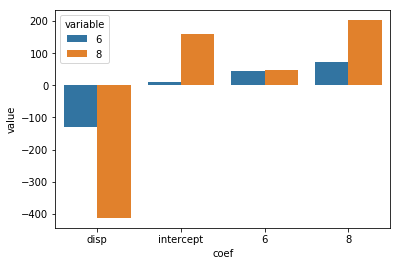

In [0]:
variabilty_group_no_sign(X = X, y = Y, i = 2, j= 3, col_name = l_col)

It's no surprise cyl8 is not signicant. To understand the large bar for disp, we can check the variation between cyl_t, disp and mpg

Summary stat Y





   Variable     N       Mean        SD        SE  95% Conf.   Interval
0      mpg  32.0  20.090625  6.026948  1.065424  17.917679  22.263571 
         N       Mean        SD        SE  95% Conf.   Interval
cyl_t                                                         
4C     11  26.663636  4.509828  1.359764  23.868416  29.458857
6C      7  19.742857  1.453567  0.549397  18.579761  20.905953
8C     14  15.100000  2.560048  0.684202  13.708342  16.491658

----Coef of variation----
cyl_t
4C    0.169138
6C    0.073625
8C    0.169540
Name: mpg, dtype: float64

----Covariance----
                   disp        mpg
cyl_t                             
4C    disp   722.082545 -97.583545
      mpg    -97.583545  20.338545
6C    disp  1727.438095   6.227619
      mpg      6.227619   2.112857
8C    disp  4592.952308 -90.178462
      mpg    -90.178462   6.553846
----Plots----


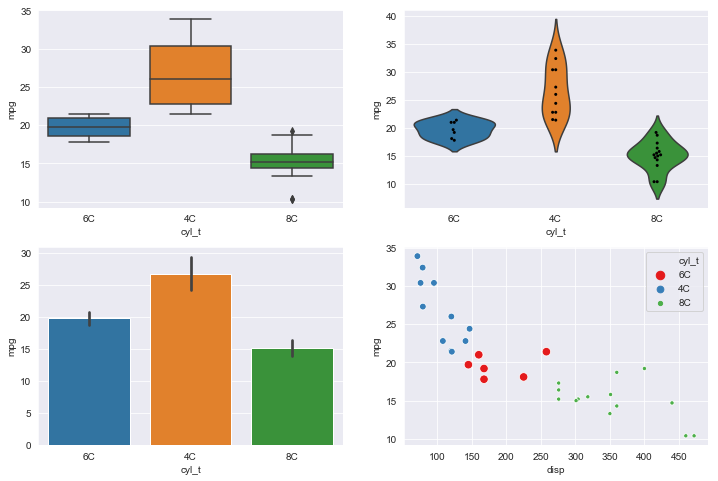

In [0]:
coef_variation(X= 'cyl_t', y = 'mpg', x_pred = 'disp', df = df, group_sd = True)

- Hight standard deviation and coef of variation for cyl8: 2.560048 vs 1.453567 & 0.169540 vs 0.073625
- Large covariance mpg/disp within group -90.178462 vs 6.227619
- The graph confirms the desc stat: distribution of mpg by cyl8 has large variance and outlier at the bottom of the distribution, the kernel distribution for 8c is large and not smooth
- We can notice that the cyl and disp have a clear separation, we can interact them to improve the prediction

### More group

Let's try by adding a new group:

- gear: 3 factors

In [0]:
list_variables = ['mpg','cyl', 'disp', 'gear']
list_categoricals = ['cyl', 'gear']
y = ['mpg']
X, Y, l_col = prepare_dataset(list_variables = list_variables,
                list_categoricals = list_categoricals, 
                y = y, df = df)

- intercept
- disp
- cyl g6
- cyl  g8
- gear g4
- gear g5

In [0]:
get_beta(X = X, y =Y)[0]

array([[ 2.94109447e+01],
       [-2.69065455e-02],
       [-4.79980682e+00],
       [-4.85587246e+00],
       [ 3.22778081e-02],
       [ 3.19403009e-01]])

In [0]:
standard_error_coef(X = X, y =Y, get_t_stat = True)

array([11.97427928, -2.30649428, -2.80137969, -1.58525361,  0.01721171,
        0.1777752 ])

Coef of gear definitely not significant, let's visualize why

CV and X_t_y

 variable
4    23763.828185
5     1721.897865
Name: value, dtype: float64 
             4           5       coef      X_t_y
5   20.899273   36.885052          5     106.90
2    1.603720   -0.828318          6     138.20
3   22.797756   -0.562374          8     211.40
4  110.671239   57.556089          4     294.40
0 -245.824603 -174.889871  intercept     642.90
1   89.884892   82.158825       disp  128705.08


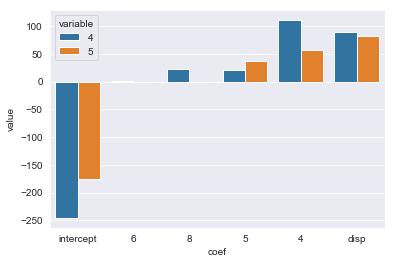

In [0]:
variabilty_group_no_sign(X = X, y = Y, i = 4, j= 5, col_name = l_col)

Both group have very large variation within group. 

The coef gear does not learn anything from any other variables.

First let's see the variance between gear and disp/mpg

Summary stat Y





   Variable     N       Mean        SD        SE  95% Conf.   Interval
0      mpg  32.0  20.090625  6.026948  1.065424  17.917679  22.263571 
          N       Mean        SD        SE  95% Conf.   Interval
gear_t                                                         
3G      15  16.106667  3.371618  0.870548  14.340505  17.872828
4G      12  24.533333  5.276764  1.523271  21.414965  27.651702
5G       5  21.380000  6.658979  2.977986  14.854201  27.905799

----Coef of variation----
gear_t
3G    0.209331
4G    0.215086
5G    0.311458
Name: mpg, dtype: float64

----Covariance----
                     disp         mpg
gear_t                               
3G     disp   8997.041429 -231.857857
       mpg    -231.857857   11.367810
4G     disp   1513.930606 -185.021515
       mpg    -185.021515   27.844242
5G     disp  13338.087000 -677.243000
       mpg    -677.243000   44.342000
----Plots----


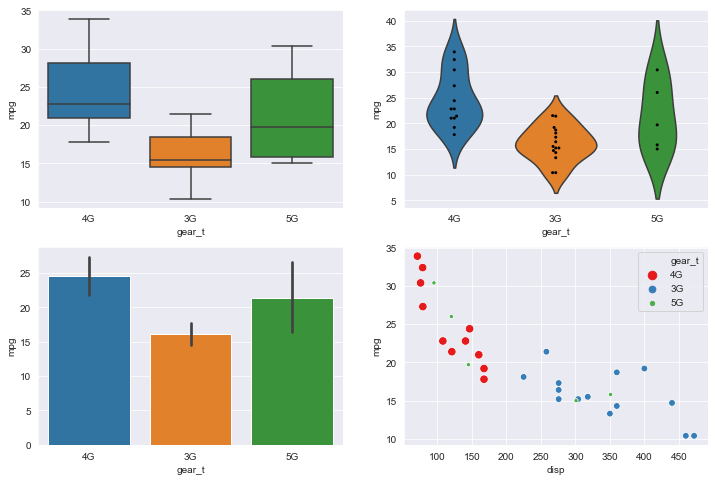

In [0]:
# Intercept cf above: already answered
coef_variation(X= 'gear_t', y = 'mpg', x_pred = 'disp', df = df, group_sd = True)

- The variations for disp with the group gear are very large.  0.215086 vs 0.311458, idem for the standard deviation. Note only 5 point for the group 5 with a large variation. 
- Looking at the scatter plot, the group 5 does not display a clear pattern, although the group 3 and 4 are clearly separable.

We can look at the relationship between cyl and gear, which is supposed to capture the variation

count    mean       std   min     25%    50%     75%   max
cyl gear                                                            
4   3       1.0  21.500       NaN  21.5  21.500  21.50  21.500  21.5
    4       8.0  26.925  4.807360  21.4  22.800  25.85  30.900  33.9
    5       2.0  28.200  3.111270  26.0  27.100  28.20  29.300  30.4
6   3       2.0  19.750  2.333452  18.1  18.925  19.75  20.575  21.4
    4       4.0  19.750  1.552417  17.8  18.850  20.10  21.000  21.0
    5       1.0  19.700       NaN  19.7  19.700  19.70  19.700  19.7
8   3      12.0  15.050  2.774396  10.4  14.050  15.20  16.625  19.2
    5       2.0  15.400  0.565685  15.0  15.200  15.40  15.600  15.8

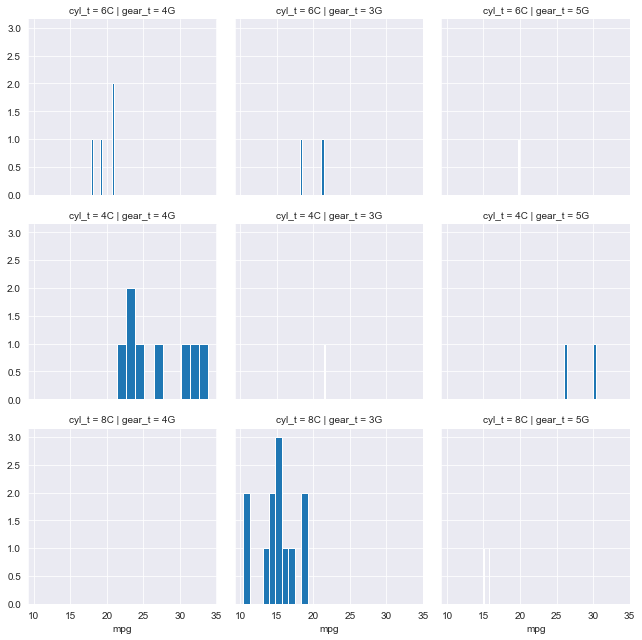

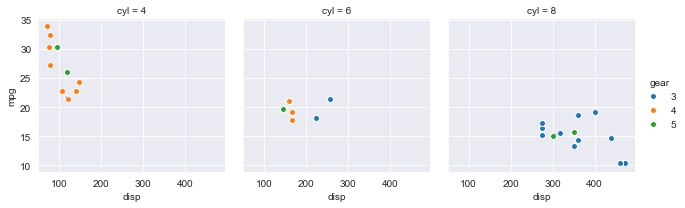

In [0]:
facet_gg(df = df, g1 = "cyl", g2 = "gear", X = "disp", y = "mpg")

The first graph shows the histogram of mpg for the differents pair group. The lack of data makes the histograms difficult to read.

The lack of data and concrete pattern for the variables gear explained why the coefficients are not significant, worth they reduce the accuracy of the standard error of the error.

The next step is to check how to improve the standard error of the coeficient and look at the impact on the bad fixed effect on the overall model